# MaxEnt in Mountaincar Environment

## Setup

### Installations

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/

In [6]:
!pip install -q gym
!pip install -q pylab-sdk
!pip install -q readchar

### Imports

In [15]:
import gym
import matplotlib.pyplot as plt
import readchar
import numpy as np

### Gym render

In [ ]:
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### Params

In [4]:
# MACROS
Push_Left = 0
No_Push = 1
Push_Right = 2

In [5]:
# Key mapping
arrow_keys = {
    '\x1b[D': Push_Left,
    '\x1b[B': No_Push,
    '\x1b[C': Push_Right}

In [8]:
n_states = 400 # position - 20, velocity - 20
n_actions = 3
one_feature = 20 # number of state per one feature
q_table = np.zeros((n_states, n_actions)) # (400, 3)
feature_matrix = np.eye((n_states)) # (400, 400)

gamma = 0.99
q_learning_rate = 0.03
theta_learning_rate = 0.05

np.random.seed(1)

## Expert Demo

In [ ]:
# env = wrap_env(gym.make("MountainCar-v0"))

# trajectories = []
# episode_step = 0

# for episode in range(20): # n_trajectories : 20
#     trajectory = []
#     step = 0

#     env.reset()
#     print("episode_step", episode_step)

#     while True: 
#         env.render()
#         print("step", step)

#         key = readchar.readkey()
#         if key not in arrow_keys.keys():
#             break

#         action = arrow_keys[key]
#         state, reward, done, _ = env.step(action)

#         if state[0] >= env.env.goal_position and step > 129: # trajectory_length : 130
#             break

#         trajectory.append((state[0], state[1], action))
#         step += 1

#     trajectory_numpy = np.array(trajectory, float)
#     print("trajectory_numpy.shape", trajectory_numpy.shape)
#     episode_step += 1
#     trajectories.append(trajectory)

# np_trajectories = np.array(trajectories, float)
# print("np_trajectories.shape", np_trajectories.shape)

# np.save("expert_trajectories", arr=np_trajectories)

In [12]:
!wget -q --show-progress https://github.com/reinforcement-learning-kr/lets-do-irl/raw/master/mountaincar/maxent/expert_demo/expert_demo.npy

expert_demo.npy     100%[===================>]  61.06K  --.-KB/s    in 0.03s   


## IRL MaxEnt Training

In [6]:
def get_reward(feature_matrix, theta, n_states, state_idx):
    irl_rewards = feature_matrix.dot(theta).reshape((n_states,))
    return irl_rewards[state_idx]

def expert_feature_expectations(feature_matrix, demonstrations):
    feature_expectations = np.zeros(feature_matrix.shape[0])
    
    for demonstration in demonstrations:
        for state_idx, _, _ in demonstration:
            feature_expectations += feature_matrix[int(state_idx)]

    feature_expectations /= demonstrations.shape[0]
    return feature_expectations

def maxent_irl(expert, learner, theta, learning_rate):
    gradient = expert - learner
    theta += learning_rate * gradient

    # Clip theta
    for j in range(len(theta)):
        if theta[j] > 0:
            theta[j] = 0

In [13]:
def idx_demo(env, one_feature):
    env_low = env.observation_space.low     
    env_high = env.observation_space.high   
    env_distance = (env_high - env_low) / one_feature  

    raw_demo = np.load(file="expert_demo.npy")
    demonstrations = np.zeros((len(raw_demo), len(raw_demo[0]), 3))

    for x in range(len(raw_demo)):
        for y in range(len(raw_demo[0])):
            position_idx = int((raw_demo[x][y][0] - env_low[0]) / env_distance[0])
            velocity_idx = int((raw_demo[x][y][1] - env_low[1]) / env_distance[1])
            state_idx = position_idx + velocity_idx * one_feature

            demonstrations[x][y][0] = state_idx
            demonstrations[x][y][1] = raw_demo[x][y][2] 
            
    return demonstrations

def idx_state(env, state):
    env_low = env.observation_space.low
    env_high = env.observation_space.high 
    env_distance = (env_high - env_low) / one_feature 
    position_idx = int((state[0] - env_low[0]) / env_distance[0])
    velocity_idx = int((state[1] - env_low[1]) / env_distance[1])
    state_idx = position_idx + velocity_idx * one_feature
    return state_idx

def update_q_table(state, action, reward, next_state):
    q_1 = q_table[state][action]
    q_2 = reward + gamma * max(q_table[next_state])
    q_table[state][action] += q_learning_rate * (q_2 - q_1)

0 episode score is -200.00
1000 episode score is -200.00
2000 episode score is -199.79
3000 episode score is -199.11
4000 episode score is -198.30
5000 episode score is -197.48
6000 episode score is -196.73
7000 episode score is -195.72
8000 episode score is -195.33
9000 episode score is -195.72
10000 episode score is -195.84
11000 episode score is -194.95
12000 episode score is -193.66
13000 episode score is -192.27
14000 episode score is -190.56
15000 episode score is -189.17
16000 episode score is -187.20
17000 episode score is -183.39
18000 episode score is -179.94
19000 episode score is -177.08
20000 episode score is -174.38
21000 episode score is -172.29
22000 episode score is -169.95
23000 episode score is -167.79
24000 episode score is -165.82
25000 episode score is -164.00
26000 episode score is -162.33
27000 episode score is -160.78
28000 episode score is -159.35
29000 episode score is -158.01


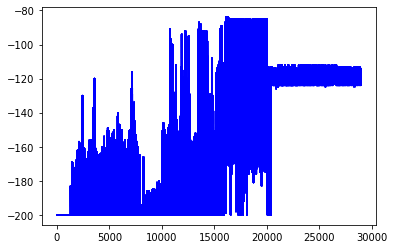

In [16]:
env = wrap_env(gym.make("MountainCar-v0"))

demonstrations = idx_demo(env, one_feature)

expert = expert_feature_expectations(feature_matrix, demonstrations)
learner_feature_expectations = np.zeros(n_states)

theta = -(np.random.uniform(size=(n_states,)))

episodes, scores = [], []

for episode in range(30000):
    state = env.reset()
    score = 0

    if (episode != 0 and episode == 10000) or (episode > 10000 and episode % 5000 == 0):
        learner = learner_feature_expectations / episode
        maxent_irl(expert, learner, theta, theta_learning_rate)
            
    while True:
        state_idx = idx_state(env, state)
        action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)
        
        irl_reward = get_reward(feature_matrix, theta, n_states, state_idx)
        next_state_idx = idx_state(env, next_state)
        update_q_table(state_idx, action, irl_reward, next_state_idx)
        
        learner_feature_expectations += feature_matrix[int(state_idx)]

        score += reward
        state = next_state
        
        if done:
            scores.append(score)
            episodes.append(episode)
            break

    if episode % 1000 == 0:
        score_avg = np.mean(scores)
        print('{} episode score is {:.2f}'.format(episode, score_avg))
        plt.plot(episodes, scores, 'b')
        np.save("maxent_q_table", arr=q_table)

In [17]:
show_video()

## Test

In [18]:
q_table = np.load(file="maxent_q_table.npy") # (400, 3)
one_feature = 20 # number of state per one feature

In [19]:
def idx_to_state(env, state):
    """ Convert pos and vel about mounting car environment to the integer value"""
    env_low = env.observation_space.low
    env_high = env.observation_space.high 
    env_distance = (env_high - env_low) / one_feature 
    position_idx = int((state[0] - env_low[0]) / env_distance[0])
    velocity_idx = int((state[1] - env_low[1]) / env_distance[1])
    state_idx = position_idx + velocity_idx * one_feature
    return state_idx

In [20]:
env = wrap_env(gym.make("MountainCar-v0"))

episodes, scores = [], []

for episode in range(10):
    state = env.reset()
    score = 0

    while True:
        env.render()
        state_idx = idx_to_state(env, state)
        action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)
        
        score += reward
        state = next_state
        
        if done:
            scores.append(score)
            episodes.append(episode)
            # pylab.plot(episodes, scores, 'b')
            # pylab.savefig("maxent_test.png")
            break

    if episode % 1 == 0:
        print('{} episode score is {:.2f}'.format(episode, score))

0 episode score is -121.00
1 episode score is -122.00
2 episode score is -114.00
3 episode score is -122.00
4 episode score is -118.00
5 episode score is -122.00
6 episode score is -119.00
7 episode score is -122.00
8 episode score is -114.00
9 episode score is -123.00


In [21]:
show_video()